In [43]:
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [98]:
def load_image(fileName):
    return mpimg.imread(fileName)

def grey_scale_conversion(img):
    new_img = np.zeros((img.shape[0],img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j,1] == 1.0:
                new_img[i,j] = 1
    return new_img

def display_image(fileName):
    imgPlot = plt.imshow(fileName)
    plt.show()

def group_patches(patches, num_images):
    return patches.reshape(num_images, -1)

def feature_extract(imgPatch):

    mean = np.mean(imgPatch, axis=(0,1))
    std = np.std(imgPatch, axis=(0,1))
    features = np.append(mean, std)
    return features

def poly_fit(X):
    """
    Fit the dataset using a polynomial basis.
    """
    poly = PolynomialFeatures(4, interaction_only=False)
    return poly.fit_transform(X)

def img_crop(img, w, h, stride, padding):

    cropList = []

    imgWidth, imgHeight =img.shape[0], img.shape[1]
    img = np.lib.pad(img, ((padding, padding), (padding, padding), (0,0)), "reflect")

    for i in range(padding,imgHeight+padding,stride):
        for j in range(padding,imgWidth+padding,stride):
            im_patch = img[j-padding:j+w+padding, i-padding:i+h+padding, :]
            cropList.append(im_patch)
    return cropList

def img_crop_gt(im, w, h, stride):
    """ Crop an image into patches (this method is intended for ground truth images). """
    assert len(im.shape) == 2, 'Expected greyscale image.'
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    for i in range(0,imgheight,stride):
        for j in range(0,imgwidth,stride):
            im_patch = im[j:j+w, i:i+h]
            list_patches.append(im_patch)
    return list_patches

def value_to_class(v):
    foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0
        
def train(Y, X):
    """
    Train this model.
    """

    foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

    def value_to_class(v):
        df = np.sum(v)
        if df > foreground_threshold:
            return 1
        else:
            return 0

    # Extract patches from input images
    img_patches = [img_crop(X[i], 16, 16, 3, 0) for i in range(X.shape[0])]
    gt_patches = [img_crop_gt(grey_scale_conversion(Y[i]), 16, 16, 3) for i in range(X.shape[0])]

    # Linearize list of patches
    img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

    X = np.asarray([feature_extract(img_patches[i]) for i in range(len(img_patches))])
    Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
    
    X = poly_fit(X)
    print('start fitting')
    logreg.fit(X, Y)

    print('Training completed')


def classify(X):
    """
    Classify an unseen set of samples.
    This method must be called after "train".
    Returns a list of predictions.
    """
    img_patches = [img_crop(X[i], 16, 16, 3, 0) for i in range(X.shape[0])]
    img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    X = np.asarray([feature_extract(img_patches[i]) for i in range(len(img_patches))])
    X = poly_fit(X)
    print('start predicting')
    Z = logreg.predict(X)
    # Regroup patches into images
    print('prediction completed')
    return group_patches(Z, X.shape[0])

In [90]:
def create_patches(X, patch_size, stride, padding):
    img_patches = np.asarray([img_crop(X[i], patch_size, patch_size, stride, padding) for i in range(X.shape[0])])
    # Linearize list
    img_patches = img_patches.reshape(-1, img_patches.shape[2], img_patches.shape[3], img_patches.shape[4])
    return img_patches
    
def create_patches_gt(X, patch_size, stride):
#     gt_patches = [img_crop_gt(grey_scale_conversion(Y[i]), 16, 16, 3) for i in range(X.shape[0])]
#     gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    img_patches = np.asarray([img_crop_gt(grey_scale_conversion(X[i]), patch_size, patch_size, stride) for i in range(X.shape[0])])
    # Linearize list
    print(img_patches.shape)
    img_patches = img_patches.reshape(-1)
    print(img_patches.shape)
    return img_patches

In [58]:
def get_classification_results(y, y_test):
    """
    Get the ratio of correct answers.
    """
    y = y.reshape(-1) # Linearize
    y_test = y_test.reshape(-1) # Linearize
    diff = y - y_test
    correct = np.sum(diff == 0)
    return correct / y_test.size



# Train Logistic Regression Model

In [52]:
if __name__ == "__main__":
    
    
    root_dir = os.getcwd() + "/sample/"
    
    image_dir = root_dir + "train_sample/"
    files = os.listdir(image_dir)
    n = len(files)
    print("Loading " + str(n) + " train images")
    imgs = np.asarray([load_image(image_dir + files[i]) for i in range(n)])

    mask_dir = root_dir + "mask_sample/"
    files = os.listdir(mask_dir)
    print("Loading " + str(n) + " mask images")
    mask_imgs = np.asarray([load_image(mask_dir + files[i]) for i in range(n)])
    
    logreg = linear_model.LogisticRegression(C=1e5)
    train(mask_imgs, imgs)
    


Loading 5 train images
Loading 5 mask images
start fitting
Training completed


# Test Image Prediction

In [104]:
root_dir = os.getcwd() + "/data/road-train-2+valid/sample_valid/"
image_dir = root_dir + "img/"
mask_dir = root_dir + "mask/"

files = os.listdir(image_dir)
test_imgs = np.asarray([load_image(image_dir + files[0])])
files = os.listdir(mask_dir)
test_mask = np.asarray([load_image(mask_dir + files[0])])
Z = classify(test_imgs)


start predicting
prediction completed


# Evaluate Accuracy

In [105]:
y_te = test_mask
# img_patches_gt = create_patches_gt(y_te, 16, 3)
# y_real = np.mean(img_patches_gt, axis=(1, 2)) > 0.25
gt_patches = [img_crop_gt(grey_scale_conversion(y_te[i]), 16, 16, 3) for i in range(y_te.shape[0])]
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
result = get_classification_results(Y, Z) 
print(result)

0.9723590164495058


# Compare results

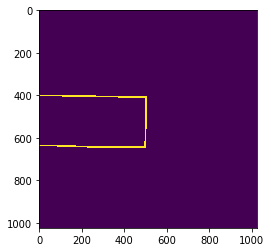

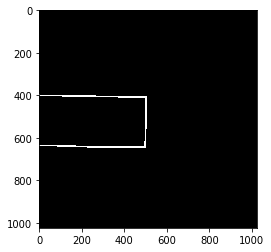

In [40]:
root_dir = os.getcwd() + "/data/road-train-2+valid/sample/"
image_dir = root_dir + "mask_sample/104_mask.png"
img = load_image(image_dir)

new_img = grey_scale_conversion(img)
plt.imshow(new_img)
plt.show()
plt.imshow(img)
plt.show()